# Business Data Analyst Test

En primer lugar, se han seguido los pasos del README para correr el docker y cargar la BBDD de postgres. A través de la consola, he consultado la BBDD y he visto que tenía 3 tablas con los nombres *message_store*, *message_store_seq_seq* y *migrations*.

A continuación, conectamos con la base de datos e importamos a dataframes de pandas las 3 tablas que hay en la base de datos.

Los primeros pasos serán para conocer los datos y de limpieza de los mismos.

## 0. Limpieza de datos

In [1]:
import psycopg2

command = """
SELECT
    *
FROM
    message_store;
"""

conn = None
try:
    conn = psycopg2.connect(host="localhost",database="test", user="test", password="test")
    cur = conn.cursor()
    cur.execute(command)
    res = cur.fetchall() 
    
    cur.close()
    conn.commit()
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
finally:
    if conn is not None:
        conn.close()

In [2]:
import pandas as pd

message_store = pd.read_sql_query('select * from message_store',con=psycopg2.connect(host="localhost",database="test", user="test", password="test"))
message_store_seq_seq = pd.read_sql_query('select * from message_store_seq_seq',con=psycopg2.connect(host="localhost",database="test", user="test", password="test"))
migrations = pd.read_sql_query('select * from migrations',con=psycopg2.connect(host="localhost",database="test", user="test", password="test"))


Mi intención, a continuación, es investigar qué contienen las tablas para saber qué información me va a ser útil para resolver el ejercicio.

In [3]:
message_store.head()

,seq,type,occurred_on,payload,stream_id,correlation_id,causation_id,id,recipient,sender,publishable,published,publish_retries,publish_error
0,1,integration.event.e_vehicle_tracked,2019-11-18 00:20:00,"{'id': '4385125b-dd1e-3025-880f-3311517cc8d5',...",4385125b-dd1e-3025-880f-3311517cc8d5,a1899246-fe3d-4ee2-9417-8a815f795f07,72b97a25-f903-4f03-8c25-7535cb9541fc,dc7c5f98-914f-451e-b1f7-9e4a74e2ef0b,None,sender,False,False,0,None
1,2,integration.event.e_vehicle_tracked,2019-11-18 00:20:00,"{'id': 'afd0b036-625a-3aa8-b639-9dc8c8fff0ff',...",afd0b036-625a-3aa8-b639-9dc8c8fff0ff,b8ea30ac-f6f4-4d42-99f7-d478b5426867,16d60dff-020e-4f47-b713-d2e99e0325ee,7f0f493c-caa0-497d-bd7d-5204905ddd28,None,sender,False,False,0,None
2,3,integration.event.e_vehicle_tracked,2019-11-18 00:20:00,"{'id': '9c45c2f1-1761-3daa-ad31-1ff8703ae846',...",9c45c2f1-1761-3daa-ad31-1ff8703ae846,aa6ab553-6a59-4ea9-943d-48fae6f9a267,a3068049-af26-4d81-955a-535d75b25469,cc074f7b-e856-4c08-a50f-c5970ee736ae,None,sender,False,False,0,None
3,4,integration.event.e_vehicle_tracked,2019-11-18 00:20:00,"{'id': '15e0ba07-10e4-3d7f-aaff-c00fed873c88',...",15e0ba07-10e4-3d7f-aaff-c00fed873c88,a7bbac0d-4901-41ac-9773-f9c2938a9bdc,a0dd7c25-344d-45a3-a0ae-43cc16cc10c3,a4113c8d-2427-4f73-ab3f-28eac76388fa,None,sender,False,False,0,None
4,5,integration.event.e_vehicle_tracked,2019-11-18 00:20:00,"{'id': 'bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60',...",bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60,59968c2f-edfb-4e97-a082-f9f266a89ee8,93bef066-8961-4f89-a8ad-d5c772181298,d8d164f6-8939-4dd1-95a1-616b33d21273,None,sender,False,False,0,None


In [4]:
message_store.shape

(270000, 14)

In [5]:
message_store_seq_seq.head()

,last_value,log_cnt,is_called
0,270028,0,True


In [6]:
display(migrations)

,version
0,20191030155255
1,20191030155255
2,20191030155255
3,20191030155255
4,20191030155255
5,20191030155255
6,20191030155255
7,20191030155255
8,20191030155255
9,20191030155255


En las líneas superiores vemos que:

* La única tabla con datos útiles es la tabla *message_store*.
* La tabla message_store contiene muchos datos que, a priori, parecen que no aportan información al ejercico.

Lo primero que me llama la atención es la columna *payload* que contiene un diccionario. Muestro una de las filas al azar:

In [8]:
message_store.payload[125250]

{'id': '27633695-d603-391f-a0c3-ae2a069976bc',
 'city': 'MADRID',
 'type': 'SCOOTER',
 'client': 'BIRD',
 'battery': 32,
 'trackId': '27633695-d603-391f-a0c3-ae2a069976bc',
 'clientId': '27633695-d603-391f-a0c3-ae2a069976bc',
 'latitude': 40.4,
 'longitude': -3.67,
 'trackedAt': '2019-12-05T12:00:00.000000Z',
 'driverTask': 'RELOCATE',
 'lastRideAt': '2019-12-05T12:00:00.000000Z',
 'userFriendlyId': '27633695-d603-391f-a0c3-ae2a069976bc'}

Finalmente veo que en dicha columna parece estar gran parte de la información que necesito. Paso a copiar el dataframe a una variable que llamo **df** en el que empiezo a limpiar los datos.

In [9]:
df = message_store.copy()

Aparentemente muchos de los datos contienen información del sistema, que no es útil para las cuestiones del ejercicio y que además están repetidas.

Hago *value_counts* para asegurar que no contienen información útil y que puedo prescindir de dichas columnas.

In [10]:
print(df.type.value_counts())
print(df.recipient.value_counts())
print(df.sender.value_counts())
print(df.publishable.value_counts())
print(df.published.value_counts())
print(df.publish_retries.value_counts())
print(df.publish_error.value_counts())

integration.event.e_vehicle_tracked    270000
Name: type, dtype: int64
Series([], Name: recipient, dtype: int64)
sender    270000
Name: sender, dtype: int64
False    270000
Name: publishable, dtype: int64
False    270000
Name: published, dtype: int64
0    270000
Name: publish_retries, dtype: int64
Series([], Name: publish_error, dtype: int64)


Elimino todas estas columnas y las columnas que no aportan información. Me quedo solo con *occurred_on* y *payload*

In [11]:
df = df[["occurred_on", "payload"]].copy()

In [12]:
df.head()

,occurred_on,payload
0,2019-11-18 00:20:00,"{'id': '4385125b-dd1e-3025-880f-3311517cc8d5',..."
1,2019-11-18 00:20:00,"{'id': 'afd0b036-625a-3aa8-b639-9dc8c8fff0ff',..."
2,2019-11-18 00:20:00,"{'id': '9c45c2f1-1761-3daa-ad31-1ff8703ae846',..."
3,2019-11-18 00:20:00,"{'id': '15e0ba07-10e4-3d7f-aaff-c00fed873c88',..."
4,2019-11-18 00:20:00,"{'id': 'bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60',..."


Para hacer más manejable la información, convierto el diccionario en columnas del dataframe.

In [13]:
df = pd.concat([df['occurred_on'], df['payload'].apply(pd.Series)], axis=1)

In [14]:
df.head()

,occurred_on,id,city,type,client,battery,trackId,clientId,latitude,longitude,trackedAt,driverTask,lastRideAt,userFriendlyId
0,2019-11-18 00:20:00,4385125b-dd1e-3025-880f-3311517cc8d5,MADRID,SCOOTER,BIRD,82,4385125b-dd1e-3025-880f-3311517cc8d5,4385125b-dd1e-3025-880f-3311517cc8d5,40.47,-3.70,2019-11-20T12:00:00.000000Z,RELOCATE,2019-11-20T12:00:00.000000Z,4385125b-dd1e-3025-880f-3311517cc8d5
1,2019-11-18 00:20:00,afd0b036-625a-3aa8-b639-9dc8c8fff0ff,MADRID,SCOOTER,BIRD,16,afd0b036-625a-3aa8-b639-9dc8c8fff0ff,afd0b036-625a-3aa8-b639-9dc8c8fff0ff,40.49,-3.66,2019-11-20T12:00:00.000000Z,RELOCATE,2019-11-20T12:00:00.000000Z,afd0b036-625a-3aa8-b639-9dc8c8fff0ff
2,2019-11-18 00:20:00,9c45c2f1-1761-3daa-ad31-1ff8703ae846,MADRID,SCOOTER,BIRD,68,9c45c2f1-1761-3daa-ad31-1ff8703ae846,9c45c2f1-1761-3daa-ad31-1ff8703ae846,40.43,-3.65,2019-11-20T12:00:00.000000Z,RELOCATE,2019-11-20T12:00:00.000000Z,9c45c2f1-1761-3daa-ad31-1ff8703ae846
3,2019-11-18 00:20:00,15e0ba07-10e4-3d7f-aaff-c00fed873c88,MADRID,SCOOTER,BIRD,77,15e0ba07-10e4-3d7f-aaff-c00fed873c88,15e0ba07-10e4-3d7f-aaff-c00fed873c88,40.40,-3.67,2019-11-20T12:00:00.000000Z,RELOCATE,2019-11-20T12:00:00.000000Z,15e0ba07-10e4-3d7f-aaff-c00fed873c88
4,2019-11-18 00:20:00,bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60,MADRID,SCOOTER,BIRD,24,bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60,bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60,40.45,-3.67,2019-11-20T12:00:00.000000Z,RELOCATE,2019-11-20T12:00:00.000000Z,bc27b4db-bc0f-34f9-ae8e-4b72f2d51b60


Volvemos a limpiar. Eliminamos id y comprobamos que hay información que no aporta nada al ejercicio y podemos eliminar. Comprobamos además que la columna *trackedAt* contiene la misma información que *lastRideAt*.

In [15]:
df["city"].value_counts()

MADRID    270000
Name: city, dtype: int64

In [16]:
df["client"].value_counts()

BIRD    270000
Name: client, dtype: int64

In [17]:
df["type"].value_counts()

SCOOTER    270000
Name: type, dtype: int64

In [18]:
df["driverTask"].value_counts()

RELOCATE    270000
Name: driverTask, dtype: int64

In [19]:
df["trackedAt"].value_counts()

2019-12-08T00:00:00.000000Z    18000
2019-12-15T12:00:00.000000Z    18000
2019-12-13T00:00:00.000000Z    18000
2019-12-25T12:00:00.000000Z    18000
2019-11-30T12:00:00.000000Z    18000
2019-12-23T00:00:00.000000Z    18000
2019-12-10T12:00:00.000000Z    18000
2019-12-18T00:00:00.000000Z    18000
2019-11-25T12:00:00.000000Z    18000
2019-12-20T12:00:00.000000Z    18000
2019-12-05T12:00:00.000000Z    18000
2019-11-23T00:00:00.000000Z    18000
2019-11-20T12:00:00.000000Z    18000
2019-12-03T00:00:00.000000Z    18000
2019-11-28T00:00:00.000000Z    18000
Name: trackedAt, dtype: int64

In [20]:
df["lastRideAt"].value_counts()

2019-12-08T00:00:00.000000Z    18000
2019-12-15T12:00:00.000000Z    18000
2019-12-13T00:00:00.000000Z    18000
2019-12-25T12:00:00.000000Z    18000
2019-11-30T12:00:00.000000Z    18000
2019-12-23T00:00:00.000000Z    18000
2019-12-10T12:00:00.000000Z    18000
2019-12-18T00:00:00.000000Z    18000
2019-11-25T12:00:00.000000Z    18000
2019-12-20T12:00:00.000000Z    18000
2019-12-05T12:00:00.000000Z    18000
2019-11-23T00:00:00.000000Z    18000
2019-11-20T12:00:00.000000Z    18000
2019-12-03T00:00:00.000000Z    18000
2019-11-28T00:00:00.000000Z    18000
Name: lastRideAt, dtype: int64

Finalmente las columnas que a priori nos pueden ser útiles son las siguientes, que alfamecenamos en un dataframe limpio de trabajo que llamo **dfw**:

In [21]:
dfw = df[["occurred_on","battery","latitude","longitude","trackedAt"]].copy()

In [22]:
dfw.dtypes

occurred_on    datetime64[ns]
battery                 int64
latitude              float64
longitude             float64
trackedAt              object
dtype: object

In [23]:
dfw.head()

,occurred_on,battery,latitude,longitude,trackedAt
0,2019-11-18 00:20:00,82,40.47,-3.70,2019-11-20T12:00:00.000000Z
1,2019-11-18 00:20:00,16,40.49,-3.66,2019-11-20T12:00:00.000000Z
2,2019-11-18 00:20:00,68,40.43,-3.65,2019-11-20T12:00:00.000000Z
3,2019-11-18 00:20:00,77,40.40,-3.67,2019-11-20T12:00:00.000000Z
4,2019-11-18 00:20:00,24,40.45,-3.67,2019-11-20T12:00:00.000000Z


A continuación, creo un par de dataframes auxiliares que contienen las filas con datos de día y datos de noche respectivamente.

Para el ejercicio he considerado que la noche empieza a las 21 y acaba a las 7 (inclusives), si bien se podrían considerar otras franjas según la necesidad.

In [27]:
df_night = dfw[(dfw["occurred_on"].dt.hour >= 21) | (dfw["occurred_on"].dt.hour <= 7)]
df_day = dfw[(dfw["occurred_on"].dt.hour < 21) | (dfw["occurred_on"].dt.hour > 7)]

Compruebo que la selección está bien realizada:

In [28]:
df_night["occurred_on"].dt.hour.value_counts()

7     11400
6     11400
5     11400
4     11400
3     11400
2     11400
1     11400
0     11300
23    11100
22    11100
21    11100
Name: occurred_on, dtype: int64

## 1. What's the battery average of the e-vehicles during the night?

In [29]:
df_night.battery.mean()

50.12709807073955

La batería media durante la noche, según el rango horario seleccionado, es de **50,13%**.

## 2. What's the battery average of the e-vehicles during the day?

In [30]:
df_day.battery.mean()

50.13271481481482

La batería media durante el día, según el rango horario seleccionado, es también de **50,13%**.

## 3. If e-vehicles must be picked-up to charge their battery when the level is lower than 40, what's the time range when most e-vehicles need to be recharged?

Por comodidad he creado un par de columnas nuevas en el df:

* Una con la hora
* Otra que llamo *need_charge* que valdrá 1 si necesita carga (la batería es menor que 40) y 0 si no necesita ser recogida (la carga es del 40% o superior)

In [31]:
dfw["hour"] = dfw["occurred_on"].dt.hour

In [32]:
dfw["need_charge"] = dfw.battery.apply(lambda x: 1 if x <40 else 0)

In [33]:
dfw.need_charge.value_counts()

0    163754
1    106246
Name: need_charge, dtype: int64

Finalmente, a través de un groupby agrupo por horas, cuento los patines que necesitan carga y los ordeno de mayor a menor según el número de patinetes.

**Se observa que el rango que más patinetes necesitan de recarga es el de 11 a 12 del mediodía.**

Sin embargo, si elegimos rangos más amplios, se pueden sacar las siguientes conclusiones:

* La noche en general necesita de más carga que el día (de 0:00 a 5 especialmente).
* En el rango horario de 8:00 a 11:00 hay un pico de necesidades de recarga (con un descenso a las 9:00).
        
El gráfico que se muestra a continuación no no es todo lo "visual" que se desearía, ya que las columnas tienen una altura muy similar. Pero con algo de atención, se observan fácilmente las conclusiones mencionadas anteriormente.

In [34]:
dfw[dfw.need_charge == 1].groupby("hour").need_charge.count().reset_index(name='count')\
                                                .sort_values(['count'], ascending=False)

,hour,count
11,11,4538
8,8,4537
0,0,4517
1,1,4510
4,4,4487
3,3,4481
10,10,4479
2,2,4477
5,5,4466
7,7,4459


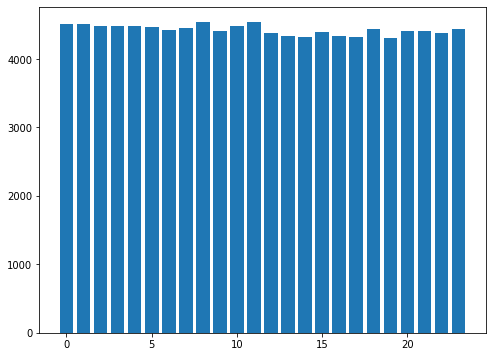

In [97]:
import matplotlib.pyplot as plt

need_battery = dfw[dfw.need_charge == 1].groupby("hour").need_charge.count().reset_index(name='count')\
                                                .sort_values(['hour'], ascending=True)
fig, ax = plt.subplots(figsize=(8, 6))

plt.bar(need_battery.hour.tolist(), need_battery["count"].tolist())
# plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.show()

## If e-vehicles must be picked-up to charge their battery when the level is lower than 40, what's the geozone with greater density of e-vehicles to be charged?

Para representar geográficamente los datos he decidido utilizar folium, una librería de python que usa de fondo leaflet.js, una librería de javascript para construir mapas interactivos.

Lo primero que hago, es agrupar los datos por latitud y longitud contando cuántos vehículos hay en cada coordenada que tengan una batería menor al 40%.

A continuación, para que la representación sea más visual, normalizo los datos de la columna *count*, restando la media y dividiendo el resultado por la desviación estándar.

He hecho dos representaciones:

* La primera de ellas he creado un rango de radios: A mayor número de vehículos que necesitan carga, mayor es el radio. Además, los 5 puntos que más carga requieren, los he puesto en rojo, para diferenciarlos de los demás que están en azul.

* La segunda representación es un mapa de calor creado con el plugin heatmap de folium.


In [147]:
coordinates = dfw[dfw.need_charge == 1].groupby(["latitude", "longitude"]).need_charge.count()\
                                .reset_index(name='count').sort_values(['count'], ascending=False)
coordinates.head()

,latitude,longitude,count
90,40.48,-3.73,1042
65,40.45,-3.65,1036
5,40.40,-3.70,1031
71,40.46,-3.70,1027
15,40.41,-3.71,1025


In [148]:
coordinates["count_aux"] = coordinates["count"].copy()

coordinates["count"] = coordinates["count"].apply(lambda x: (x-coordinates["count"].mean())/coordinates["count"].std())

In [150]:
import folium
import statistics

lat = list(coordinates.latitude)
lon = list(coordinates.longitude)
count = list(coordinates["count"])

map = folium.Map(location=[df_charge.latitude.mean(), df_charge.longitude.mean()], zoom_start=12)

for e in range(len(lat)):
    latitude = lat[e]
    longitude = lon[e]
    
    if count[e] < 0.2:
        radio = 150
    elif count[e] <0.4:
        radio = 200
    elif count[e] < 0.6:
        radio = 250
    elif count[e] < 0.8:
        radio = 300
    else:
        radio = 400
    
    if e in range(5):
        folium.Circle([latitude, longitude],
                        radius=radio,
                        color = "red",
                        fill_color= '#f03',
                        fill=True
                       ).add_to(map)
    else:
        folium.Circle([latitude, longitude],
                        radius=radio,
                        fill=True
                       ).add_to(map)
map

In [140]:
from folium.plugins import HeatMap

def generateBaseMap(default_location=[dfw.latitude.mean(), dfw.longitude.mean()], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

base_map = generateBaseMap()
HeatMap(data=coordinates[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=15, max_zoom=13).add_to(base_map)
base_map

## Could you display on a heat map the density of e-vehicles in a timeline? Basically, we should be able to see how the density varies on the map as we change the timestamp.

En este punto me he encontrado un problema. Folium permite realizar esto con el plugin *HeatMapWithTime*, sin embargo, parece que no funciona muy bien. 

No he podido ponerlo en marcha, pero es que tampoco puedo ver [los ejemplos de su página web](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/HeatMapWithTime.ipynb).

Investigando por internet he visto que da fallos si tienes activado adblocks. He probado en varios navegadores y en varios ordenadores y no he conseguido ni siquiera ver el ejemplo, así que finalmente decidí realizarlo de otra manera.

El código que utilicé es el siguiente.

Los datos deben estar en una lista:

In [175]:
coordinates_time = dfw.groupby(["occurred_on", "latitude", "longitude"]).need_charge.count().reset_index(name='count')\
                                                .sort_values(['occurred_on'], ascending=True)

coordinates_time["count_aux"] = coordinates_time["count"].copy()
coordinates_time.head()

,occurred_on,latitude,longitude,count,count_aux
0,2019-11-18 00:20:00,40.40,-3.75,1,1
37,2019-11-18 00:20:00,40.45,-3.69,2,2
38,2019-11-18 00:20:00,40.45,-3.67,1,1
39,2019-11-18 00:20:00,40.45,-3.65,1,1
40,2019-11-18 00:20:00,40.46,-3.75,1,1


In [169]:
df_hour_list = []
for hour in coordinates_time["occurred_on"].dt.hour.sort_values().unique():
    df_hour_list.append(coordinates_time.loc[coordinates_time["occurred_on"].dt.hour == hour, ['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())

In [170]:
from folium.plugins import HeatMapWithTime

base_map2 = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_hour_list, radius=15, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, auto_play=True, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map2)
base_map2

Por ellos, he decidio realizar este ejercicio con leaflet. Para ello he creado un pequeño documento html que contiene el script de Javascript para mostrar el mapa en leaflet.

Para realizarlo, utilizo el plugin de leaflet **Leaflet.TimeDimension**.

Lo primero que necesito es una nested list que contenga en el primer elemento el timestamp (en ms, que es lo que requiere el plugin) y en el segundo, una lista con todas las coordenadas donde hay vehículos a esa hora. Además, también recojo los pesos, es decir, cuántos vehículos hay en cada coordenada a cada hora.

En primer lugar creo una nested list **con todos los datos** que contengan: el timestamp en ms, latitud, longitud y el peso.

In [176]:
from datetime import datetime

coordinates_time.occurred_on = coordinates_time.occurred_on.apply(lambda x: x.timestamp()*1000)

times = coordinates_time.values.tolist()
times.sort(key = lambda x: x[0]) 
times

[[1574036400000.0, 40.4, -3.75, 1.0, 1.0],
 [1574036400000.0, 40.45, -3.69, 2.0, 2.0],
 [1574036400000.0, 40.45, -3.67, 1.0, 1.0],
 [1574036400000.0, 40.45, -3.65, 1.0, 1.0],
 [1574036400000.0, 40.46, -3.75, 1.0, 1.0],
 [1574036400000.0, 40.46, -3.73, 4.0, 4.0],
 [1574036400000.0, 40.46, -3.71, 2.0, 2.0],
 [1574036400000.0, 40.46, -3.68, 1.0, 1.0],
 [1574036400000.0, 40.46, -3.66, 1.0, 1.0],
 [1574036400000.0, 40.46, -3.65, 1.0, 1.0],
 [1574036400000.0, 40.47, -3.71, 1.0, 1.0],
 [1574036400000.0, 40.47, -3.7, 2.0, 2.0],
 [1574036400000.0, 40.47, -3.69, 2.0, 2.0],
 [1574036400000.0, 40.47, -3.68, 1.0, 1.0],
 [1574036400000.0, 40.48, -3.75, 2.0, 2.0],
 [1574036400000.0, 40.48, -3.74, 2.0, 2.0],
 [1574036400000.0, 40.48, -3.73, 1.0, 1.0],
 [1574036400000.0, 40.48, -3.72, 3.0, 3.0],
 [1574036400000.0, 40.49, -3.65, 1.0, 1.0],
 [1574036400000.0, 40.49, -3.66, 3.0, 3.0],
 [1574036400000.0, 40.49, -3.69, 1.0, 1.0],
 [1574036400000.0, 40.49, -3.7, 1.0, 1.0],
 [1574036400000.0, 40.49, -3.71, 1.

Creamos la nested list que queremos en la variable *date*.

In [178]:
date = []
date_aux = []
weight = []
for time in times:
    if not time[0] in date_aux:
        date_aux.append(time[0])
        date.append([time[0]])
        date[len(date)-1].append([[time[1],time[2]]])
    else:
        date[len(date)-1][1].append([time[1],time[2]])
    weight.append(time[3])

# Convertimos weigth a entero
weight = [int(i) for i in weight]
date

[[1574036400000.0,
  [[40.4, -3.75],
   [40.45, -3.69],
   [40.45, -3.67],
   [40.45, -3.65],
   [40.46, -3.75],
   [40.46, -3.73],
   [40.46, -3.71],
   [40.46, -3.68],
   [40.46, -3.66],
   [40.46, -3.65],
   [40.47, -3.71],
   [40.47, -3.7],
   [40.47, -3.69],
   [40.47, -3.68],
   [40.48, -3.75],
   [40.48, -3.74],
   [40.48, -3.73],
   [40.48, -3.72],
   [40.49, -3.65],
   [40.49, -3.66],
   [40.49, -3.69],
   [40.49, -3.7],
   [40.49, -3.71],
   [40.49, -3.72],
   [40.45, -3.7],
   [40.49, -3.73],
   [40.48, -3.66],
   [40.48, -3.67],
   [40.48, -3.68],
   [40.48, -3.69],
   [40.48, -3.7],
   [40.48, -3.71],
   [40.49, -3.74],
   [40.45, -3.72],
   [40.47, -3.66],
   [40.45, -3.75],
   [40.42, -3.68],
   [40.42, -3.69],
   [40.42, -3.7],
   [40.42, -3.71],
   [40.42, -3.74],
   [40.41, -3.65],
   [40.43, -3.74],
   [40.41, -3.67],
   [40.41, -3.71],
   [40.41, -3.75],
   [40.4, -3.67],
   [40.4, -3.68],
   [40.4, -3.69],
   [40.45, -3.73],
   [40.41, -3.7],
   [40.43, -3.73],
   

Por último, creamos el documento html.

Se puede construir con el plugin TimeDimension un script que te dibuje el mapa de calor como hacía folium. Sin embargo, no he tenido el tiempo suficiente como para saber cómo.

Por el momento, presento un mapa de calor por cuadrículas donde cada una de ellas es más opaco, si hay más concentración de vehículos, o menos, si la concentración es más baja.

El máximo de vehículos a la misma hora y en el mismo lugar es de 7, que es cuando la cuadrícula es totalmente opaca. No obstante, no estaría mal una leyenda.

Seguiré trabajando en ello (en la leyenda y el heatmap).

El código de acontinuación, crea el archivo html. Si se corre la celda del notebook, se abré directamente la página en el navegador. También se puede descargar el repositorio y abrir el archivo *maps.html* que se encuentra en el directorio *html.



In [179]:
import webbrowser

html = """
    <html>
    <head>
        <style>
        #mapid { height: 180px; }
        </style>
        <title>Leaflet Heatmap with time</title>        
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.5.1/dist/leaflet.css" />
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet-timedimension@1.1.1/dist/leaflet.timedimension.control.min.css" />
    <body>
    <header>
    
    </header>
    <div id="mapid" style="width: 100%; height: 100%;"></div>
    <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/leaflet@1.5.1/dist/leaflet.js"></script>
    <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/iso8601-js-period@0.2.1/iso8601.min.js"></script>
    <script type="text/javascript" src="https://cdn.jsdelivr.net/npm/leaflet-timedimension@1.1.1/dist/leaflet.timedimension.min.js"></script>

    <script>
    
    L.TimeDimension.Layer.GeoJson.GeometryCollection = L.TimeDimension.Layer.GeoJson.extend({

    // Do not modify features. Just return the feature if it intersects
    // the time interval    
    _getFeatureBetweenDates: function(feature, minTime, maxTime) {
        var featureStringTimes = this._getFeatureTimes(feature);
        if (featureStringTimes.length == 0) {
            return feature;
        }
        var featureTimes = [];
        for (var i = 0, l = featureStringTimes.length; i < l; i++) {
            var time = featureStringTimes[i]
            if (typeof time == 'string' || time instanceof String) {
                time = Date.parse(time.trim());
            }
            featureTimes.push(time);
        }

        if (featureTimes[0] > maxTime || featureTimes[l - 1] < minTime) {
            return null;
        }
        return feature;
    },

});

L.timeDimension.layer.geoJson.geometryCollection = function(layer, options) {
    return new L.TimeDimension.Layer.GeoJson.GeometryCollection(layer, options);
};

    var map = L.map('mapid', {
    timeDimension: true,
    timeDimensionOptions: {
        timeInterval: "2019-11-18/2019-12-25",
        period: "PT1H"
    },
    timeDimensionControl: true,
    timeDimensionControlOptions:{
        timeSteps: 24
    }
}).setView([""" + str(df_charge.latitude.mean()) + """, """ + str(df_charge.longitude.mean()) + """], 13);


function getCommonBaseLayers(map){
    L.tileLayer('http://{s}.tile.osm.org/{z}/{x}/{y}.png').addTo(map);

}

// Create and add a TimeDimension Layer to the map
var geoJsonFeatures = {
  "type": "FeatureCollection",
  "crs": {
    "type": "name",
    "properties": {
    "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
    },
  },
  "features": [ """

contador = 1
for timestamp in date:
    html += """{
        "type": "Feature",
        "properties": {
          "time": """ + str(timestamp[0]) + """,
          "id": """ + str(contador) + """,
          "opacity":  """ + str(1 if weight[contador-1] == 7 else \
                                0.92 if weight[contador-1] == 6 else \
                                0.84 if weight[contador-1] == 5 else \
                                0.76 if weight[contador-1] == 4 else \
                                0.68 if weight[contador-1] == 3 else \
                                0.6 if weight[contador-1] == 2 else \
                                0.5 ) + """
        },
        "geometry": {
          "type": "GeometryCollection",
          "geometries": [ """
    
    for coord in timestamp[1]:
        html += """{
            "type": "Polygon",
            "coordinates": [[
        [""" + str(coord[1]-0.005) + """, """ + str(coord[0]-0.005) + """],
        [""" + str(coord[1]+0.005) + """, """ + str(coord[0]-0.005) + """],
        [""" + str(coord[1]+0.005) + """, """ + str(coord[0]+0.005) + """],
        [""" + str(coord[1]-0.005) + """, """ + str(coord[0]+0.005) + """],
        [""" + str(coord[1]-0.005) + """, """ + str(coord[0]-0.005) + """]
        ]]
        },"""
    
    contador += 1
    
    html += """]
        }
      },"""

html += """]
};


var geoJsonLayer = L.geoJson(geoJsonFeatures, {
  style: function(feature) {    
    return {
      "color": "#FF0000",
      "opacity": 0,
      "fillOpacity": feature.properties.opacity
    };
  }
});



map.fitBounds(geoJsonLayer.getBounds());

var geoJsonTimeLayer = L.timeDimension.layer.geoJson.geometryCollection(geoJsonLayer, {
  updateTimeDimension: true,
  updateTimeDimensionMode: 'replace',
  duration: 'PT30M',
});


geoJsonTimeLayer.addTo(map);

var baseLayers = getCommonBaseLayers(map);

</script>

    <footer>
        <p>Alfonso Román Bonachera</p>
    </footer>
    </body>
    </html>
    """

with open("html/maps.html", "w") as file:
    file.write(html)
    
webbrowser.open("html/maps.html")

True